In [140]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

In [141]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [142]:
df2.iloc[:, 9:15]

,A7,A8,A9,A10,A11,A12
0,0.0938,0.0933,0.0947,0.094,0.0945,0.0923
1,0.0933,0.0932,0.0948,0.0937,0.0937,0.0923
2,0.0932,0.0933,0.0948,0.0939,0.0939,0.0927
3,0.0934,0.0935,0.095,0.0941,0.0941,0.0926
4,0.0938,0.0939,0.0954,0.0945,0.0945,0.0929
...,...,...,...,...,...,...
337,0.5901,0.6007,0.5678,0.5227,0.5631,0.308
338,0.5898,0.6002,0.5683,0.5222,0.5616,0.3055
339,0.5889,0.5999,0.5681,0.5221,0.5621,0.3051
340,0.5888,0.5992,0.5675,0.5211,0.561,0.3032


In [143]:
c=-1
P_exp=np.array(df2.iloc[:, 9:14])
T_exp=np.array(df2['Time [s]'])

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
N_exp,T_max, T_exp.shape, P_exp.shape

(5, 231399.5, (342,), (342, 5))

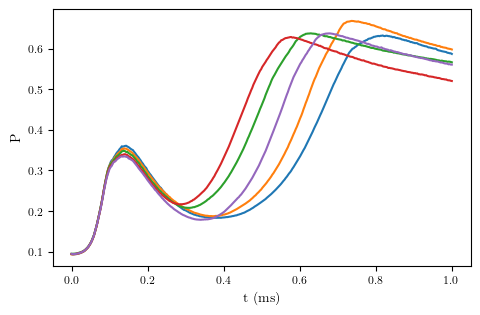

In [144]:
for i in range(N_exp):
    plt.plot(T_exp,P_exp[:, i])
plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

In [145]:
N_f = 1000 # Number of residual point
N_d = 500 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
P0=P_exp[0,:]
T_meshgrid, P0_meshgrid, = np.meshgrid(T_exp, P0)
X_star = np.hstack((T_meshgrid.flatten()[:,None], P0_meshgrid.flatten()[:,None]))
u_star=np.hstack((P_star,P0_meshgrid.flatten()[:,None]))


# T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

# Initial Condition
xx0 = X_star[::len(T_exp)]
uu0 = P_star[::len(T_exp)]

xx1= np.hstack((np.ones(len(P0)).reshape([-1,1]), P0.reshape([-1,1])))

xx01=np.vstack((xx0, xx1))
uu01=np.array([1]*N_exp+[0]*N_exp).reshape([-1,1])

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu0), replace=False)
xxd = X_star[idx]
uud = P_star[idx]

X_u_train = np.concatenate((xx0,xxd))
P_train = np.concatenate((uu0,uud))

X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
P_train_tf =   tf.convert_to_tensor(P_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)
xx01_tf = tf.convert_to_tensor(xx01, dtype=tf.float32)
uu01_tf = tf.convert_to_tensor(uu01, dtype=tf.float32)

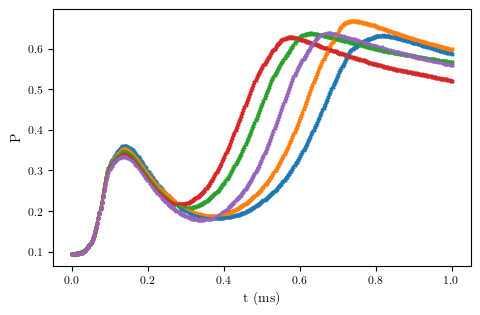

In [146]:
L_exp=len(P_exp[:,1])
for i in range(N_exp):
    plt.plot(X_star[L_exp*i:L_exp*(i+1)][:,0],P_exp[:, i])
    plt.scatter(X_star[L_exp*i:L_exp*(i+1)][:,0],P_star[L_exp*i:L_exp*(i+1)], marker='x', s=5)

plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

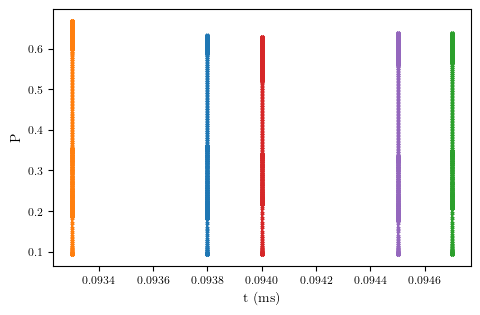

In [147]:
L_exp=len(P_exp[:,1])
for i in range(N_exp):
    plt.plot(X_star[L_exp*i:L_exp*(i+1)][:,1],P_exp[:, i])
    plt.scatter(X_star[L_exp*i:L_exp*(i+1)][:,1],P_star[L_exp*i:L_exp*(i+1)], marker='x', s=5)

plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

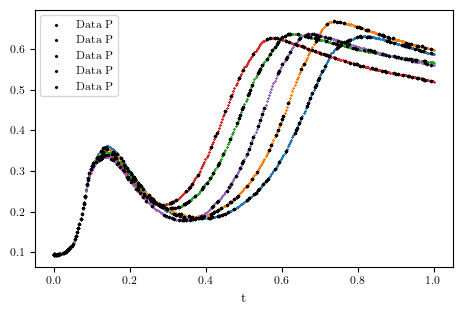

In [148]:
L_exp=len(P_exp[:,1])
for i in range(N_exp):
    plt.scatter(X_star[L_exp*i:L_exp*(i+1)][:,0],P_star[L_exp*i:L_exp*(i+1)], marker='x', s=1)
    plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

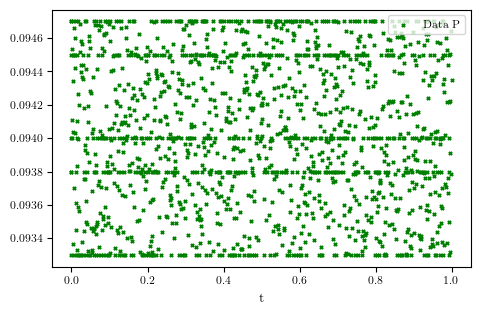

In [149]:

plt.scatter(X_f_train_tf[:,0], X_f_train_tf[:,1], s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [150]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def train_vars_total(W, b, lambda_r, lambda_b):
    return W + b + lambda_r + lambda_b

def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r+N_b, 2]), dtype=tf.float32)
    alpha_s = tf.Variable(tf.ones(shape=[N_r+N_b, 1]), dtype=tf.float32)
    alpha_a = tf.Variable(tf.ones(shape=[N_r+N_b, 1]), dtype=tf.float32)
    alpha_0 = tf.Variable(tf.reshape(tf.repeat(1000.0, N_exp*4), ( N_exp*4, -1))) 


    return alpha_r, alpha_b, alpha_s, alpha_a, alpha_0

#@tf.function(jit_compile=True)
@tf.function()
def net_f(X_f, W_p, b_p, W_phi_s, b_phi_s, W_phi_a, b_phi_a, lnv):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([X_f])
        u=net(X_f, W_p, b_p)

        lnp=u[:,0:1]
        lns=u[:,1:2]
        lna=u[:,2:3]

        p=tf.exp(lnp)
        s=tf.exp(lns)
        a=tf.exp(lna)

        m=tf.exp(lnv[0:1])
        l=tf.exp(lnv[1:2])
        d=tf.exp(lnv[2:3])
        m2=tf.exp(lnv[3:4])
        l2=tf.exp(lnv[4:5])


        # lnphi_s = net(tf.concat([p, s],1), W_phi_s, b_phi_s)
        # lnphi_a = net(tf.concat([p, a],1), W_phi_a, b_phi_a)
        # phi_s=tf.exp(lnphi_s)
        # phi_a=tf.exp(lnphi_a)


    p_t = tape1.gradient(p, X_f)[...,0:1]
    s_t = tape1.gradient(s, X_f)[...,0:1]
    a_t = tape1.gradient(a, X_f)[...,0:1]

    f_p = p_t - m2*p*s + l2*p*a + d*p
    f_a = a_t + l*p*a
    f_s = s_t + m*p*s
    
    return f_p, f_s, f_a


#@tf.function()
# @tf.function()
def train_step(W_p, b_p,  W_phi_s, b_phi_s, W_phi_a, b_phi_a,  X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_s,  lambda_0, lnv, opt):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi_s, b_phi_s, W_phi_a, b_phi_a, lambda_r, lambda_0, lambda_s, lnv])
        u_nn = net(X_u_train_tf, W_p, b_p) 
        lnp=u_nn[:,0:1]
        p_nn=tf.exp(lnp)

        f_p, f_s, f_a = net_f(X_f_train_tf, W_p, b_p, W_phi_s, b_phi_s, W_phi_a, b_phi_a, lnv)

        u_00 = net(xx01_tf, W_p, b_p) 
        lns_0=u_00[:,1:2]
        lna_0=u_00[:,2:3]
        a_00=tf.exp(lna_0)
        s_00=tf.exp(lns_0)

        loss_p = tf.square(lambda_b*(p_nn - P_train_tf))
        # loss_0a = tf.square(lambda_0[:N_exp*2]*(a_00 - uu01_tf))
        loss_0a = tf.square(lambda_0[:N_exp*2]*(a_00 - uu01_tf))
        loss_0s = tf.square(lambda_0[N_exp*2:]*(s_00 - uu01_tf))
        loss_fp = tf.square(lambda_r[0:1]*f_p) 
        loss_fa = tf.square(lambda_r[1:2]*f_a) 
        loss_fs = tf.square(lambda_s*f_s) 


        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp)+ tf.reduce_mean(loss_fa)+ tf.reduce_mean(loss_fs)+ tf.reduce_mean(loss_0s) + tf.reduce_mean(loss_0a)  

    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    # grads_phi_s = tape.gradient(loss, train_vars(W_phi_s, b_phi_s))
    # grads_phi_a = tape.gradient(loss, train_vars(W_phi_a, b_phi_a))



    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    grads_s = tape.gradient(loss, lambda_s)
    grads_0 = tape.gradient(loss, lambda_0)
    grads_lnv = tape.gradient(loss, lnv)


    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    opt.apply_gradients(zip([-grads_s], [lambda_s]))
    opt.apply_gradients(zip([-grads_0], [lambda_0]))
    opt.apply_gradients(zip([grads_lnv], [lnv]))
  

    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    # opt.apply_gradients(zip(grads_phi_s, train_vars(W_phi_s, b_phi_s)))
    # opt.apply_gradients(zip(grads_phi_a, train_vars(W_phi_a, b_phi_a)))


   
    return loss, tf.reduce_mean(tf.square((p_nn - P_train_tf))), tf.reduce_mean(tf.square(f_p)), tf.reduce_mean(tf.square(f_s)), tf.reduce_mean(tf.square(f_a))



layers = [2, 20, 20, 3]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]


layers = [2, 20, 20, 1]
L = len(layers)

W_phi_s= [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi_s = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [2, 20, 20, 1]
L = len(layers)

W_phi_a= [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi_a = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]



lambda_r, lambda_b, lambda_s, lambda_a, lambda_0 = loss_weight(N_f, N_d)
lnv = tf.Variable(tf.reshape(tf.repeat(1.0, 5), (5, -1)), dtype=tf.float32) 


@tf.function()
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred


In [151]:
xx01_tf,N_exp

(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[0.    , 0.0938],
        [0.    , 0.0933],
        [0.    , 0.0947],
        [0.    , 0.094 ],
        [0.    , 0.0945],
        [1.    , 0.0938],
        [1.    , 0.0933],
        [1.    , 0.0947],
        [1.    , 0.094 ],
        [1.    , 0.0945]], dtype=float32)>,
 5)

In [152]:
lr = 1e-3
# Nmax = 15000
# Nmax = 150000
Nmax=10**5
Nmax=18*10**3
# Nmax=20000



optimizer = tf.optimizers.Adam(learning_rate=lr)
optimizer2 = tf.optimizers.Adam(learning_rate=lr/10)
# optimizer3 = tf.optimizers.Adam(learning_rate=lr/100)
# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
optimizer3 = tf.optimizers.Adam(learning_rate=lr/50)

# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9, clipnorm=10.0)


start_time = time.time()
n=0
loss = []
loss_d = []
loss_fisp = []
loss_fiss = []
loss_reg=[]
loss_fisa = []

# Make a new Function and ConcreteFunction for each optimizer.
train_step_1 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi_s, b_phi_s, W_phi_a, b_phi_a, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_s,  lambda_0, lnv, optimizer)
train_step_2 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi_s, b_phi_s, W_phi_a, b_phi_a, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_s,  lambda_0, lnv, optimizer)
train_step_3 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi_s, b_phi_s, W_phi_a, b_phi_a, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_s,  lambda_0, lnv, optimizer)


while n <= Nmax:
    if n<10**5:
        loss_, loss_p, loss_fp, loss_fs, loss_fa = train_step_1(W_p, b_p, W_phi_s, b_phi_s, W_phi_a, b_phi_a, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_s,  lambda_0, lnv)
    elif n< 2*10**5:
        loss_, loss_p, loss_fp, loss_fs, loss_fa = train_step_2(W_p, b_p, W_phi_s, b_phi_s, W_phi_a, b_phi_a, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_s,  lambda_0, lnv)
    else:
        loss_, loss_p, loss_fp, loss_fs, loss_fa = train_step_3(W_p, b_p, W_phi_s, b_phi_s, W_phi_a, b_phi_a, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_s,  lambda_0, lnv)

    loss.append(loss_)
    loss_d.append(loss_p)
    loss_fisp.append(loss_fp)
    loss_fiss.append(loss_fs)
    loss_fisa.append(loss_fa)



    if n % 10 == 0:

        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")
        # print(f"Data loss is: {loss_p}")
        print(f"Physicial loss of p is: {loss_fp}")
        print(f"Physicial loss of s is: {loss_fs}")
        # if n%10000 ==0:
        #     loss_reg_=eval(W_p, b_p, W_phi_s, b_phi_s)
        #     loss_reg.append(loss_reg_)
        # print(f"Physicial loss of a is: {loss_fa}")

    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 1720329.25
Physicial loss of p is: 9.112486839294434
Physicial loss of s is: 3.5695338249206543
Iteration is: 10
Total loss is: 1135815.375
Physicial loss of p is: 8.537421226501465
Physicial loss of s is: 3.494530200958252
Iteration is: 20
Total loss is: 721927.25
Physicial loss of p is: 6.945991516113281
Physicial loss of s is: 2.1373815536499023
Iteration is: 30
Total loss is: 473291.875
Physicial loss of p is: 4.780099391937256
Physicial loss of s is: 0.7234152555465698
Iteration is: 40
Total loss is: 302856.53125
Physicial loss of p is: 3.3193562030792236
Physicial loss of s is: 0.21821820735931396
Iteration is: 50
Total loss is: 181753.09375
Physicial loss of p is: 2.5325658321380615
Physicial loss of s is: 0.052806366235017776
Iteration is: 60
Total loss is: 108809.984375
Physicial loss of p is: 2.094115972518921
Physicial loss of s is: 0.06059936061501503
Iteration is: 70
Total loss is: 71119.5
Physicial loss of p is: 1.9520530700683594
Physicial 

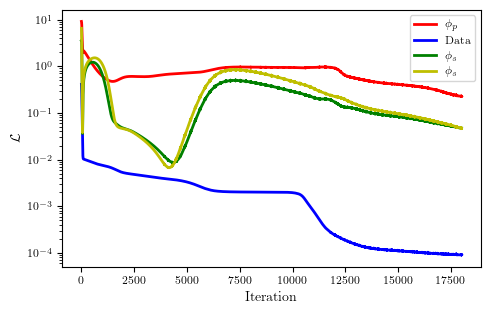

In [153]:
Nmax=len(loss)
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_data_list = [loss_d[i].numpy() for i in range(0,Nmax)]
loss_phip_list = [loss_fisp[i].numpy() for i in range(0,Nmax)]
loss_phis_list = [loss_fiss[i].numpy() for i in range(0,Nmax)]
loss_phia_list = [loss_fisa[i].numpy() for i in range(0,Nmax)]
# Nreg=len(loss_reg)
# it_r = np.arange(0,Nmax- Nmax%10000 +1, 10000)

# loss_reg_list = [loss_reg[i].numpy() for i in range(0,Nreg)]

# loss_phia_list = [loss_fisa[i].numpy() for i in range(0,Nmax)]


plt.semilogy(it, np.asarray(loss_phip_list), 'r-', linewidth = 2, label = '$\phi_p$') 

plt.semilogy(it, np.asarray(loss_data_list), 'b-', linewidth = 2, label = 'Data')  

plt.semilogy(it, np.asarray(loss_phis_list), 'g-', linewidth = 2, label = '$\phi_s$')  
plt.semilogy(it, np.asarray(loss_phia_list), 'y-', linewidth = 2, label = '$\phi_s$')  
# plt.semilogy(it_r, np.asarray(loss_reg_list), 'black', linewidth = 2, label = '$\phi_r$')    


# plt.semilogy(it, np.asarray(loss_phia_list), 'y-', linewidth = 2, label = '$\phi_a$')       



plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')  
plt.legend()  
# plt.savefig('figures/loss_phi.pdf')
plt.show()

In [154]:
lnv[0], tf.exp(lnv[0]), lnv[1], tf.exp(lnv[1]), lnv[2], tf.exp(lnv[2]), lnv[3], tf.exp(lnv[3]), lnv[4], tf.exp(lnv[4])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.4356365], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([31.05117], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.41457], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([30.403875], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.58419055], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.7935386], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([6.2226787], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([504.0516], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([6.1883535], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([487.04355], dtype=float32)>)

In [155]:


## Evaluating total function
# T_star_tf = tf.convert_to_tensor(X_star[:len(T_exp)], dtype=tf.float32)    
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)    

u_pred = predict(X_star_tf, W_p, b_p)

# ## Evaluating unknown function
lnp=u_pred[:,0:1]
lns=u_pred[:,1:2]
lna=u_pred[:,2:3]

p=tf.exp(lnp)
s=tf.exp(lns)
a=tf.exp(lna)
phi_ps = tf.exp(predict(tf.concat([p, s],1), W_phi_s, b_phi_s))
phi_pa = tf.exp(predict(tf.concat([p, a],1), W_phi_a, b_phi_a))

m=tf.exp(lnv[0:1])
l=tf.exp(lnv[1:2])
d_=tf.exp(lnv[2:3])
m2=tf.exp(lnv[3:4])
l2=tf.exp(lnv[4:5])


phi_p=m2*p*s-l2*p*a-d_*p



phi_s=np.array(p*s*m)
phi_a=np.array(p*a*l)


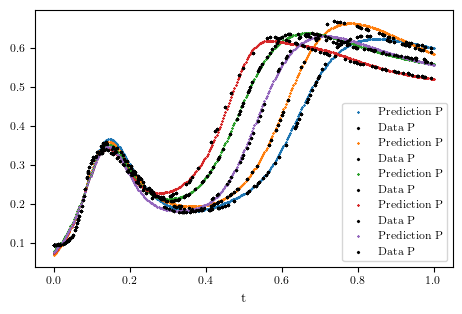

In [156]:
for i in range(N_exp):
    plt.scatter(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], marker='x', s=1,  label='Prediction P')
    plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

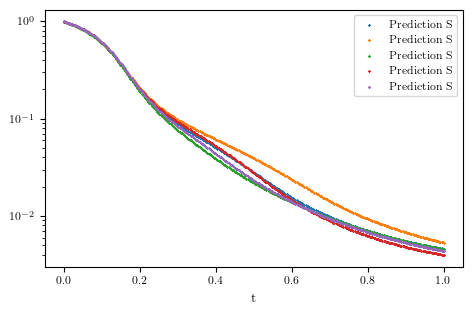

In [157]:
for i in range(N_exp):
    plt.scatter(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], marker='x', s=1,  label='Prediction S')


plt.legend()
plt.xlabel('t')
plt.yscale('log')
# plt.xscale('log')

# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

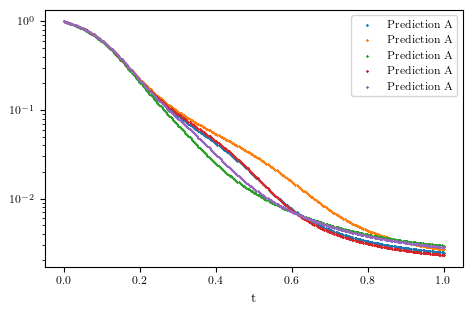

In [158]:
for i in range(N_exp):
    plt.scatter(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], a[L_exp*i:L_exp*(i+1)], marker='x', s=1,  label='Prediction A')

plt.legend()
plt.xlabel('t')
plt.yscale('log')
# plt.savefig('figures/P_phi.pdf')
plt.show()

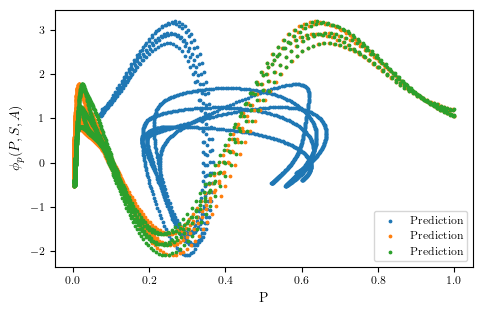

In [159]:
plt.scatter(p, phi_p, s=3, label='Prediction')
plt.scatter(a, phi_p, s=3, label='Prediction')
plt.scatter(s, phi_p, s=3, label='Prediction')

# plt.plot(u_pred[:,1:2], phi_pred, label='Prediction')

# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('P')
plt.ylabel('$\phi_p(P,S,A)$')
# plt.savefig('figures/phi.pdf')
plt.show()

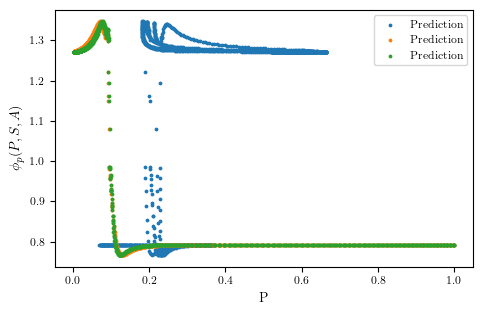

In [160]:
plt.scatter(p, phi_pa, s=3, label='Prediction')
plt.scatter(a, phi_pa, s=3, label='Prediction')
plt.scatter(s, phi_pa, s=3, label='Prediction')

# plt.plot(u_pred[:,1:2], phi_pred, label='Prediction')

# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('P')
plt.ylabel('$\phi_p(P,S,A)$')
# plt.savefig('figures/phi.pdf')
plt.show()

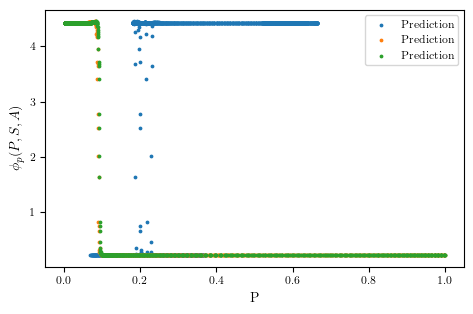

In [161]:
plt.scatter(p, phi_ps, s=3, label='Prediction')
plt.scatter(a, phi_ps, s=3, label='Prediction')
plt.scatter(s, phi_ps, s=3, label='Prediction')

# plt.plot(u_pred[:,1:2], phi_pred, label='Prediction')

# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('P')
plt.ylabel('$\phi_p(P,S,A)$')
# plt.savefig('figures/phi.pdf')
plt.show()

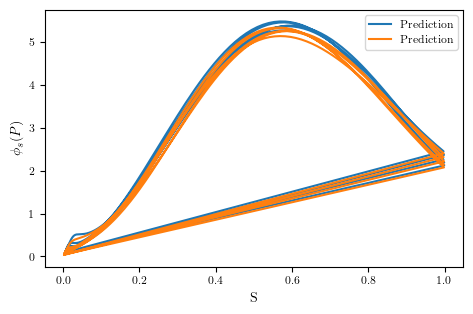

In [162]:
plt.plot(s, phi_s, label='Prediction')
plt.plot(a, phi_a, label='Prediction')

# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('S')
plt.ylabel('$\phi_s(P)$')
# plt.savefig('figures/phi.pdf')
plt.show()

In [163]:
P0

array([0.09380000084638596, 0.093299999833107, 0.09470000118017197,
       0.09399999678134918, 0.09449999779462814], dtype=object)

In [164]:
Nt=1000
T_int=np.zeros(Nt)
P_int=np.zeros(Nt)
S_int=np.zeros(Nt)
A_int=np.zeros(Nt)


dt=0.001

T_int[0]=0
P_int[0]=np.mean(P0) #Initial conditions
# P_int[0]=np.array(p[0]) #Initial conditions

S_int[0]=np.array(s[0]) #Initial conditions
A_int[0]=np.array(a[0]) #Initial conditions



for i in range(1,Nt):

    # # PSA=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(A_int[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    # PS=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    # PA=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(A_int[i-1].reshape([-1,1]), dtype=tf.float32)],1)

    # PHI_S=tf.exp(predict(PS , W_phi_s, b_phi_s))
    # PHI_A=tf.exp(predict(PA , W_phi_a, b_phi_a))

    P_int[i]=P_int[i-1]+(m2*S_int[i-1]-l2*A_int[i-1]-np.array(d_))*P_int[i-1]*dt
    A_int[i]=A_int[i-1]-P_int[i-1]*A_int[i-1]*np.array(l)*dt
    S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]*np.array(m)*dt
    T_int[i]=T_int[i-1]+dt

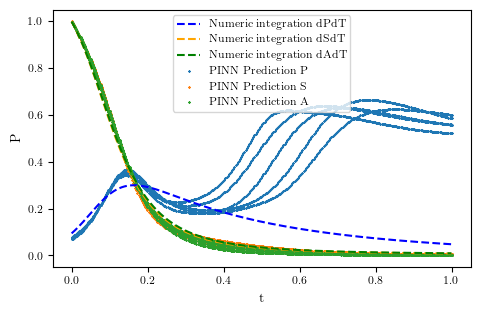

In [165]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')
plt.plot(T_int, A_int, color='green', linestyle='--', label='Numeric integration dAdT')



plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
plt.scatter(X_star_tf[:,0], s, marker='x', s=1,  label='PINN Prediction S')
plt.scatter(X_star_tf[:,0], a, marker='x', s=1,  label='PINN Prediction A')
# 

plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

In [166]:
gcghnm,

NameError: name 'gcghnm' is not defined

# Symbolic Regresion

# PHI_S

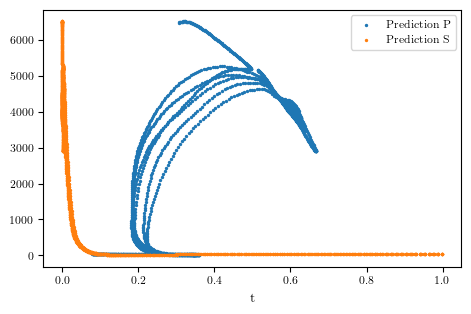

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.    , 0.0938], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9970674, 0.0923   ], dtype=float32)>)

In [319]:
c=0
d=-1
plt.scatter( p[c:d], phi_ps[c:d], s=2, label='Prediction P')
plt.scatter( s[c:d], phi_ps[c:d], s=2, label='Prediction S')
# plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()
X_star_tf[c:d][0], X_star_tf[c:d][-1]

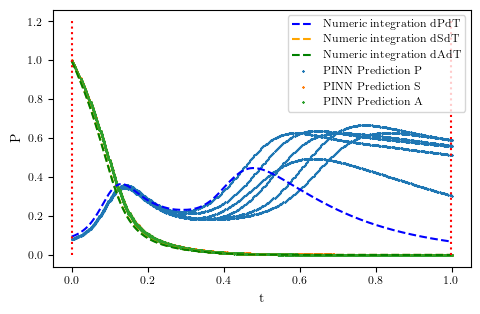

In [320]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')
plt.plot(T_int, A_int, color='green', linestyle='--', label='Numeric integration dAdT')




plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
plt.scatter(X_star_tf[:,0], s, marker='x', s=1,  label='PINN Prediction S')
plt.scatter(X_star_tf[:,0], a, marker='x', s=1,  label='PINN Prediction A')


plt.vlines(X_star_tf[c:d][:,0][0],0,1.2, color='red', linestyle=':')
plt.vlines(X_star_tf[c:d][:,0][-1],0,1.2, color='red', linestyle=':')


plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

In [140]:
model_s = PySRRegressor(
    niterations=150,
    binary_operators=["+", "*", "/", "^"],
    # binary_operators=["+", "*", "inv(x, y) = x/(x + y)", "^"],

    # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
    # unary_operators=["inv(x) = 1/x"],
    extra_sympy_mappings={
            "inv": lambda x, y: x/(x+y),
        },
    # extra_sympy_mappings={"inv": lambda x: 1/x},
    constraints={"inv": (1, 3), '^': (1, 1)},
    # complexity_of_operators={"/": 2},
    parsimony=0.0000001,
    # denoise=True,
    complexity_of_variables=2,
    # complexity_of_constants=2,

    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    random_state=42,   # Fija la semilla
    # select_k_features=1,
    maxsize=25,
)

In [141]:
# p1s=tf.concat([p1[c:d], s[c:d]], axis=1)

min_cols_phi_s= tf.math.reduce_min(phi_ps[c:d], axis=0)
max_cols_phi_s= tf.math.reduce_max(phi_ps[c:d], axis=0)

phi_ps_scaled = (phi_ps[c:d]-min_cols_phi_s)/(max_cols_phi_s-min_cols_phi_s)
PS_tf=tf.concat([p[c:d], s[c:d]],1)

model_s.fit( PS_tf,phi_ps_scaled)
print(model_s)


c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:1310: UserWarning: Note: Setting `random_state` without also setting `deterministic` to True and `procs` to 0 will result in non-deterministic searches. 
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 9.300e+04
Head worker occupation: 18.4%
Progress: 210 / 2250 total iterations (9.333%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           2.480e-01  1.594e+01  y = 0.79951
2           6.696e-02  1.309e+00  y = x₀
4           5.795e-02  7.230e-02  y = x₀ / 0.81806
6           5.421e-02  3.331e-02  y = (x₀ * 1.5419) + -0.14944
7           4.625e-02  1.589e-01  y = x₀ / (0.77084 + x₁)
8           8.505e-03  1.693e+00  y = 0.94265 / (1.0271 + (x₁ / 0.010743))
10          8.324e-03  1.075e-02  y = 0.17505 * (0.96312 / ((x₁ / 0.049926) + 0.17505))
11          5.487e-03  4.167e-01  y = 0.75675 / (((x₁ / 0.011004) + 0.24428) + x₀)
13          5.260e-03  2.118e-02  y = 0.90386 / (x₀ + (((x₁ / 0.42891) / 0.020698) + 0.39903))
16          3.974e-03  9.343e-02  y = (0.25084 / (x₀ + ((x₁ / 0.42973) / (x₀ * 0.12803)))) * 1.8...
                      

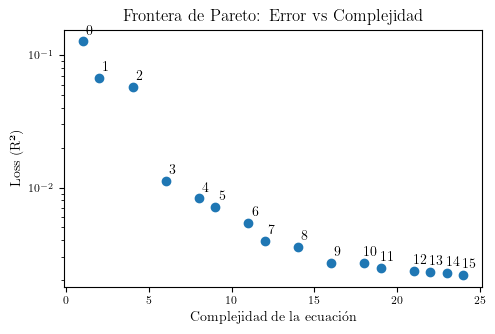

In [143]:
# Extraer las métricas de las ecuaciones
equations_df = model_s.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.yscale('log')
plt.show()

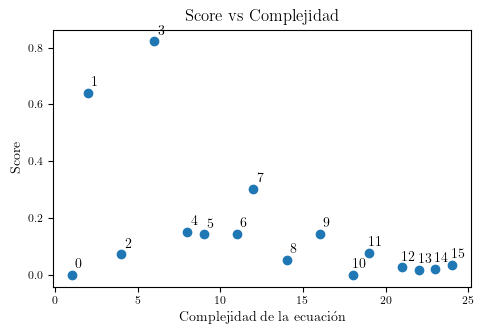

In [144]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [280]:
chose_s=6
expr=model_s.sympy(chose_s)*(max_cols_phi_s-min_cols_phi_s)+min_cols_phi_s
expr
sympy.expand(expr)

7.59294843673706 + 3130.27306240811/(x0 + 93.1220951726437*x1 + 0.23962058)

In [281]:
sympy.simplify(expr)


(7.59294843673706*x0 + 707.071266966805*x1 + 3132.09248911643)/(x0 + 93.1220951726437*x1 + 0.23962058)

In [282]:
sympy.factor(expr)


33.6342570827008*(0.00242424144980439*x0 + 0.225750443010153*x1 + 1.0)/(0.01073859*x0 + 1.0*x1 + 0.0025731871641822)

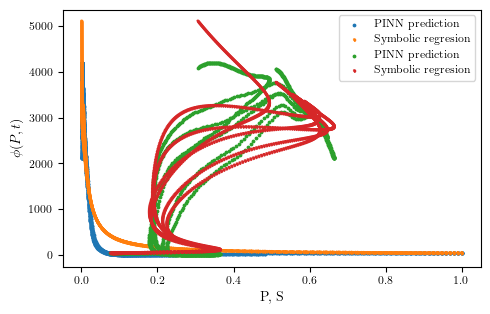

In [283]:
symb_s=model_s.predict(tf.concat([p, s],1),chose_s)
symb_s=symb_s*(max_cols_phi_s-min_cols_phi_s)+min_cols_phi_s
plt.scatter(s, phi_ps, s=3, label='PINN prediction')
plt.scatter(s, symb_s, s=3,  linestyle='--', label='Symbolic regresion')
plt.scatter(p, phi_ps, s=3, label='PINN prediction')
plt.scatter(p, symb_s, s=3,  linestyle='--', label='Symbolic regresion')
# plt.plot(tf.concat([p, s],1), 15.38-1.18*s, linestyle='--', label=r'$s\approx 0$')

# plt.plot( s, 200/(13+s), label='Real S')

plt.xlabel('P, S')
plt.ylabel('$\phi (P,t)$')
plt.legend()
plt.show()

# PHI_A


(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.    , 0.0938], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9970674, 0.0923   ], dtype=float32)>)

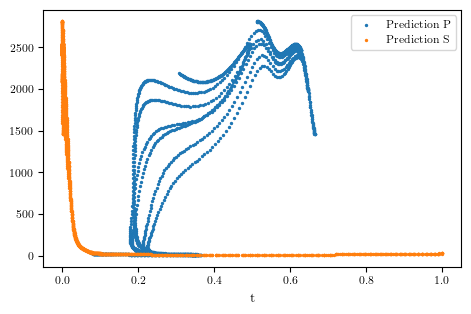

In [ ]:
c=0
d=-1
plt.scatter( p[c:d], phi_pa[c:d], s=2, label='Prediction P')
plt.scatter( a[c:d], phi_pa[c:d], s=2, label='Prediction S')
# plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
X_star_tf[c:d][0], X_star_tf[c:d][-1]

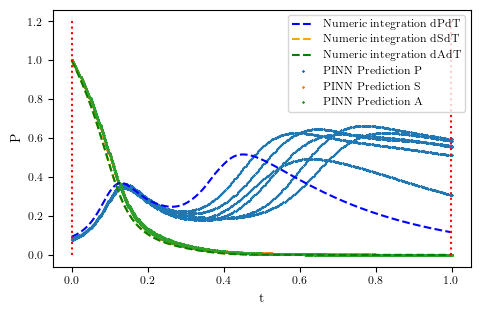

In [185]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')
plt.plot(T_int, A_int, color='green', linestyle='--', label='Numeric integration dAdT')




plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
plt.scatter(X_star_tf[:,0], s, marker='x', s=1,  label='PINN Prediction S')
plt.scatter(X_star_tf[:,0], a, marker='x', s=1,  label='PINN Prediction A')


plt.vlines(X_star_tf[c:d][:,0][0],0,1.2, color='red', linestyle=':')
plt.vlines(X_star_tf[c:d][:,0][-1],0,1.2, color='red', linestyle=':')


plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

In [186]:
model_a = PySRRegressor(
    niterations=200,
    binary_operators=["+", "*", "/", "^"],
    # binary_operators=["+", "*", "inv(x, y) = x/(x + y)", "^"],

    # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
    # unary_operators=["inv(x) = 1/x"],
    extra_sympy_mappings={
            "inv": lambda x, y: x/(x+y),
        },
    # extra_sympy_mappings={"inv": lambda x: 1/x},
    constraints={"inv": (1, 3), '^': (1, 1)},
    # complexity_of_operators={"/": 2},
    parsimony=0.0000001,
    # denoise=True,
    # complexity_of_variables=2,
    # complexity_of_constants=2,

    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    random_state=42,   # Fija la semilla
    # select_k_features=1,
    # maxsize=40,
)

In [189]:
# p1s=tf.concat([p1[c:d], s[c:d]], axis=1)

min_cols_phi_pa= tf.math.reduce_min(phi_pa[c:d], axis=0)
max_cols_phi_pa= tf.math.reduce_max(phi_pa[c:d], axis=0)

phi_pa_scaled = (phi_pa[c:d]-min_cols_phi_pa)/(max_cols_phi_pa-min_cols_phi_pa)
PA_tf=tf.concat([p[c:d], a[c:d]],1)

model_a.fit( PA_tf,phi_pa_scaled)
print(model_a)


c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:1310: UserWarning: Note: Setting `random_state` without also setting `deterministic` to True and `procs` to 0 will result in non-deterministic searches. 
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 9.890e+04
Head worker occupation: 24.8%
Progress: 231 / 3000 total iterations (7.700%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           7.531e-02  1.594e+01  y = x₀
3           5.463e-02  1.605e-01  y = x₀ * 1.3368
5           3.954e-02  1.617e-01  y = x₀ / (0.70285 + x₁)
7           6.967e-03  8.681e-01  y = 0.22549 / ((x₁ / 0.039617) + 0.23224)
9           5.957e-03  7.833e-02  y = (0.25703 / (0.25371 + (x₁ / 0.048374))) + -0.067708
11          5.606e-03  3.037e-02  y = (x₀ / (((x₁ ^ 1.2281) / 0.017152) + x₀)) * 0.88503
13          4.155e-03  1.497e-01  y = 0.30158 / (((((x₁ / 0.030935) + 0.3451) * x₁) / 0.030935) ...
                                  + 0.3451)
15          4.132e-03  2.739e-03  y = 0.30158 / ((((x₁ + ((x₁ / 0.030935) + 0.3451)) * x₁) / 0.0...
                                  30935) + 0.3451)
17          3.996e-03  

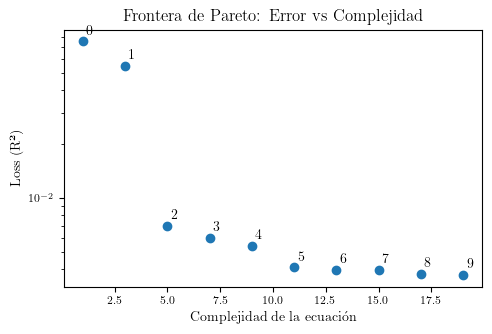

In [191]:
# Extraer las métricas de las ecuaciones
equations_df = model_a.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.yscale('log')
plt.show()

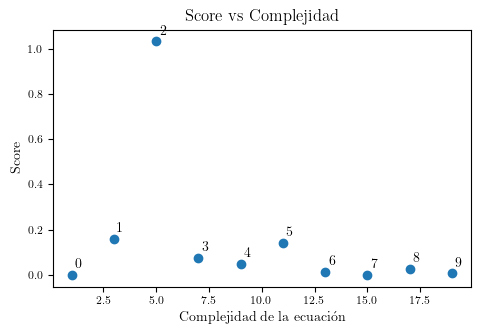

In [192]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [248]:
chose_a=5
expr=model_a.sympy(chose_a)*(max_cols_phi_pa-min_cols_phi_pa)+min_cols_phi_pa
expr
sympy.expand(expr)

10.5554571151733 + 762.877132308508/(1763.6501802783*x1**2 + 0.32109135)

In [249]:
sympy.simplify(expr)


(18616.1338440953*x1**2 + 766.266398283486)/(1763.6501802783*x1**2 + 0.32109135)

In [250]:
sympy.factor(expr)


10.5554571151733*(1.0*x1**2 + 0.0411614143248402)/(1.0*x1**2 + 0.000182060679374258)

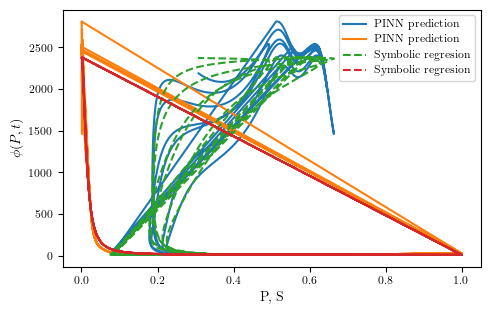

In [253]:
symb_a=model_a.predict(tf.concat([p, a],1),chose_a)
symb_a=symb_a*(max_cols_phi_pa-min_cols_phi_pa)+min_cols_phi_pa
plt.plot(tf.concat([p[c:d], a[c:d]],1), phi_pa[c:d], label='PINN prediction')
plt.plot(tf.concat([p, a],1), symb_a, linestyle='--', label='Symbolic regresion')
# plt.plot(tf.concat([p, s],1), 15.38-1.18*s, linestyle='--', label=r'$s\approx 0$')

# plt.plot( s, 200/(13+s), label='Real S')

plt.xlabel('P, S')
plt.ylabel('$\phi (P,t)$')
plt.legend()
plt.show()

# INT SYMB

In [284]:
Nt=1000
T_symb=np.zeros(Nt)
P_symb=np.zeros(Nt)
S_symb=np.zeros(Nt)
A_symb=np.zeros(Nt)

dt=0.001

T_symb[0]=0
# P_symb[0]=np.array(p[0]) #Initial conditions
P_symb[0]=np.mean(P0)  #Initial conditions

S_symb[0]=np.array(s[0]) #Initial conditions
A_symb[0]=np.array(a[0]) #Initial conditions


for i in range(1,Nt):
    PS_p=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    PA_p=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(A_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    # PHI_S=tf.exp(predict(PS_p , W_phi_s, b_phi_s))
    PHI_A=tf.exp(predict(PA_p , W_phi_a, b_phi_a))

    PHI_S=model_s.predict(PS_p, chose_s)*(max_cols_phi_s-min_cols_phi_s)+min_cols_phi_s
    # PHI_A=model_a.predict(PA_p, chose_a)*(max_cols_phi_pa-min_cols_phi_pa)+min_cols_phi_pa

    P_symb[i]=P_symb[i-1]+(PHI_S*S_symb[i-1]-PHI_A*A_symb[i-1]-np.array(d_+0.2))*P_symb[i-1]*dt
    S_symb[i]=S_symb[i-1]-P_symb[i-1]*S_symb[i-1]*np.array(l)*dt
    A_symb[i]=A_symb[i-1]-P_symb[i-1]*A_symb[i-1]*np.array(m)*dt
    T_symb[i]=T_symb[i-1]+dt

In [285]:
m, l, d_

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[42.71995]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[42.72977]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.0359862]], dtype=float32)>)

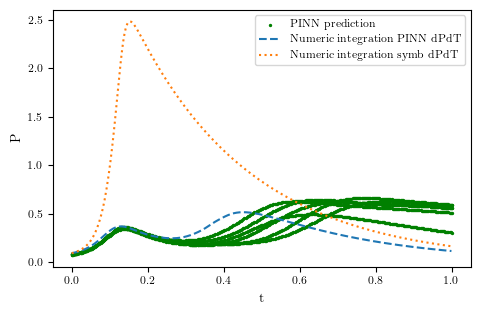

In [286]:
plt.scatter(X_star_tf[:,0], p, s=2, color='green', label='PINN prediction')
plt.plot(T_int, P_int, linestyle='--', label='Numeric integration PINN dPdT')
plt.plot(T_symb, P_symb, linestyle=':', label='Numeric integration symb dPdT')

plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

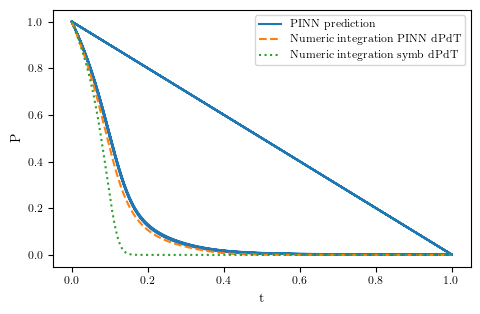

In [287]:
plt.plot(X_star_tf[:,0], s, label='PINN prediction')
plt.plot(T_int, S_int, linestyle='--', label='Numeric integration PINN dPdT')
plt.plot(T_symb, S_symb, linestyle=':', label='Numeric integration symb dPdT')

plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

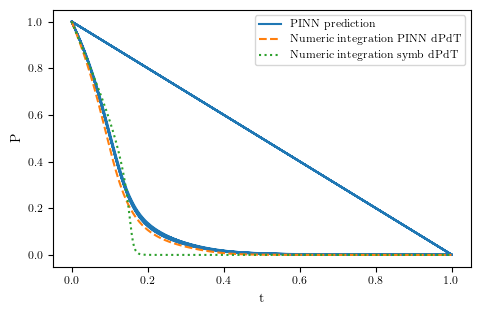

In [264]:
plt.plot(X_star_tf[:,0], a, label='PINN prediction')
plt.plot(T_int, A_int, linestyle='--', label='Numeric integration PINN dPdT')
plt.plot(T_symb, A_symb, linestyle=':', label='Numeric integration symb dPdT')

plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()